# 23.10.11 라이브 수업 정리

### 오늘의 목표? - 댓글 기능 구현

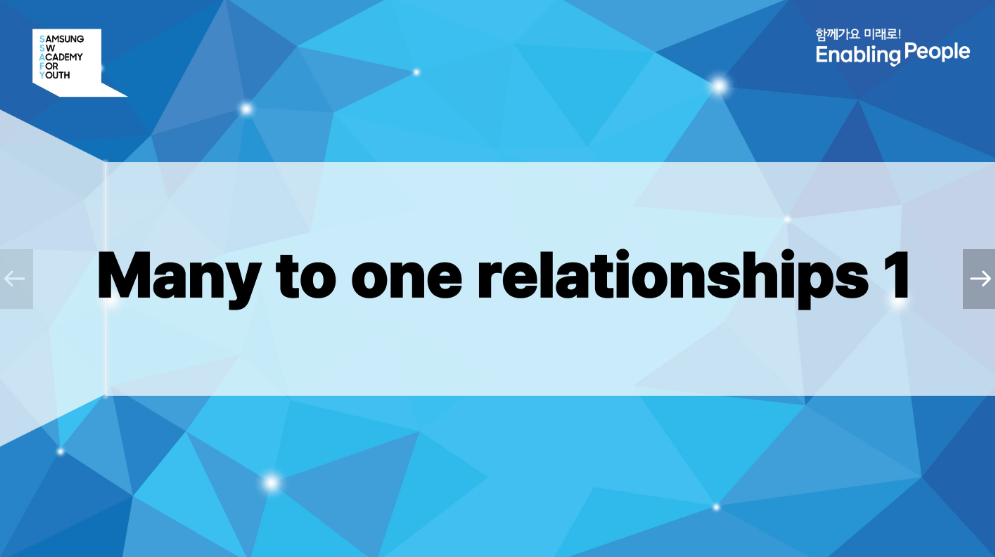

### Many to one relationships (N:1 or 1:N)
한 테이블의 0개 이상의 레코드가 다른 테이블의 레코드 한 개와 관련된 관계

### Comment - Article (N:1)
0개 이상의 댓글은 1개의 게시글에 작성 될 수 있다


## 이제 테이블을 설계 해야함

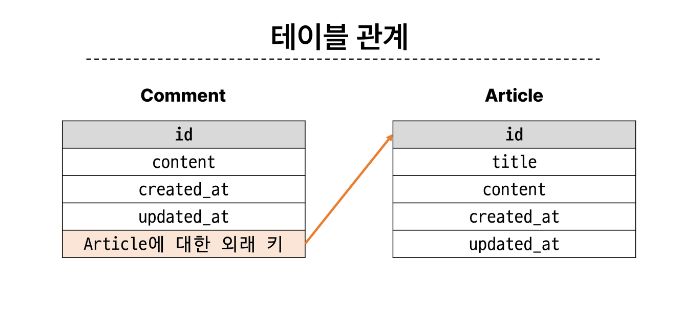

- 댓글(comment)엔 제목(title) 필요X
- 관계(두 테이블간의 논리적인 연결 - 외래키(Foreign Key)를 통해 연결 ex.JOIN)
- comment가 article에 대한 외래 키가 필요함!!
- N:1 관계에서 외래키는 N쪽이 들고있게 됨

### ForeignKey() - N:1 관계 설정 모델 필드
외래키에 대한 모델필드를 comment class 를 생성하면서 만들어야함
=> ForeignKey()   외래키를 만들어주는 새로운 모델 필드!

## < 댓글 모델 구현 >

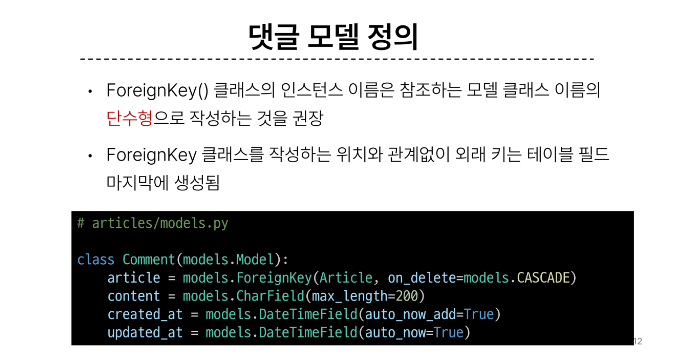

* 장고에서의 APP 목적 : 기능단위의 모듈로서 나눔
accounts : 인증, 유저 // articles : 게시판/글
-> 댓글 articles

새로운 class를 만듦 - models에서 상속을 받기 때문에 column의 이름과 데이터 타입/제약조건 만 신경써주면 됨!!
외래키 article 만 신경 써주기

In [ ]:
class Comment(models.Model):
    content = models.CharField(max_length=200)
    created_at = models.DateTimeField(auto_now_add=True)
    updated_at = models.DateTimeField(auto_now=True)
    // 외래키는 class의 소문자 형태로 권장 (N:1관계에서)
    // on_delete : 게시글 작성자가 게시글을 지웠을 때 어떻게 할 것인지(대표적으로 같이 지움/댓글이 있는 게시글 삭제X 등)
    article = models.ForeignKey(Article, on_delete=models.CASCADE)
    

### ForeignKey(to, on_delete)
to : 참조하는 모델 class 이름
on_delete : 외래키가 참조하는 객체(1)가 사라졌을 때, 외래키를 가진 객체(N)를 어떻게 처리할지를 정의하는 설정 (데이터 무결성-어떻게든 처리해야함)

** CASCADE : 부모객체(참조된객체)가 삭제되었을 때 이를 참조하는 객체도 삭제


(진행상황) 모델 필드에 class comment를 설정한 후 -> migration 진행! - 댓글 생성 연습(in shell pluse)

** 장고에서는 orm이 모델클래스를 작성하면 sql - db 순으로 알아서 바꾸어줌
우리가 배운 sql 형식으로 클래스 데이터를 보는 명령어 :
python manage.py sqlmigrate articles 0002

- django shell 실행 : python manage.py shell_plus


1. 우선 게시글 만들어주기
In [1]: article = Article(title='title', content='content')

In [2]: article.save()


2. 댓글 만들기

In [4]: comment = Comment()

In [5]: comment.content = '댓글씀

In [6]: comment.save()
IntegrityError: NOT NULL constraint failed: articles_comment.article_id
-> NULL 값을 허용하지 않는걸 통과하지 못함! article 댓글테이블에 외래키 필드에 해당하는 id가 누락되었다!
-> 이 댓글이 어느 게시글에 작성되는 것인지를 모름 
```
In [7]: comment.article = article

In [8]: comment.save()
```
-> 객체로 생각 후 저장

3. 1번 댓글이 달린 게시글의 내용은 무엇인가? : 결합 필요 (sql-join / 장고-객체지향)
```
In [10]: comment.article              // 객체로 생각하면 접근가능
Out[10]: <Article: Article object (1)>

In [11]: comment.article.content       // 외래키데이터를 N이 들고있기때문에 참조가능
Out[11]: 'content'
```

4. 1번 댓글이 달린 게시글의 번호는? - 접근 방법 - pk로 주로 사용
ex1) comment.article_id
ex2) comment.article.pk

5. 2번째 댓글 생성  (1번게시글에 댓글 2개 만듦)
```
In [13]: comment = Comment(content='댓글2', article=article)

In [14]: comment.save()
```


## < 관계 모델 참조 >

이때까지 댓글(N)쪽에서 글(1)만 참조하고 있었음    // N->1 (참조)
-> 댓글이 어떤 게시글에 작성되었는지를 조회 가능

글(1) -> 댓글(N) 참조              // 1->N (역참조)
-> 해당 게시글에 작성된 모든 댓글을 조회 - 물리적으로 불가(게시글에는 댓글에 대한 정보가 존재하지 X, 별도의 역참조 이름이 필요함!! - manager이용)


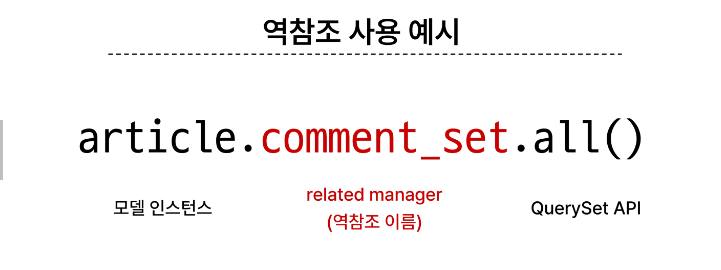

- related manager (역참조 시에 장고가 자동으로 사용하는 매니저)

이름 규칙
- 이름은 참조하는 "모델명_set" 이름 규칙으로 만들어짐
- 해당 댓글의 게시글( commnet -> article : comment.article ) - 참조
- 게시글의 댓글 목록 ( article -> commnet : article.comment_set.all() ) - 역참조



6. 1번 게시글에 대한 모든 댓글 조회
```
In [15]: article.comment_set.all()
Out[15]: <QuerySet [<Comment: Comment object (1)>, <Comment: Comment object (2)>]>

In [18]: for comment in comments:
    ...:     print(comment.content)
    ...: 
댓글씀
댓글2

```

## < 실제 댓글 구현! - CommentForm 정의 >

1. articles/forms.py 에서 class CommentForm 생성!
- .models 에서 아까 만든 class Comment import 해주기

2. 댓글 보이게 만들기 - view의 detail 함수 수정 - detail.html 수정
주의) forms에서 모든 필드를 받아오지 말고, 'content'만 받아오기!

3. Comment 클래스의 article(외래키)를 어디서 받아와야하는지??!
articles 의 url update!!
```
// url
    path('<int:pk>/comments/', views.comments_create, name='comments_create'),


// views
def detail(request, pk):
    article = Article.objects.get(pk=pk)
    comment_form = CommentForm()

    # 특정 게시글의 모든 댓글을 조회(역참조)
    commets = article.comment_set.all()
    context = {
        'article': article,
        'comment_form': comment_form,
        'commets': commets,
        
    }
    return render(request, 'articles/detail.html', context)
    

def comments_create(req, pk):
    # 게시글 조회 - 댓글을 생성할 때 어떤 게시글에 다는지 확인해야하기 때문
    article = Article.objects.get(pk=pk)
    # CommentForm으로 사용자로 부터 데이터를 입력 받음
    comment_form = CommentForm(req.POST)
    if comment_form.is_valid():
        comment = comment_form.save(commit=False)
        comment.article = article
        comment_form.save()
        return redirect('articles:detail', article.pk)
    
    context = {
        'comment_form': comment_form,
    }
    return render(req, 'articles/detail.html', context)

```

3. 댓글 삭제






유저 1 게시글 N - column 은 게시글에 추가 - 유저번호 붙일 수 있음
comment조회 - select이용해서 그냥 조회 가능 - comment.object.all() 하면 article id 다 들어있음
article 입장에서 나한테 달린 댓글을 가지고 오기 - 역참조 매니저 이용해서 가져오기

comment_form.save()
commtne.save() - DB 인스턴트에 있는 것 save한것
둘다 써도 상관 X